In [2]:
import os 
from IPython.display import clear_output

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 11})

import warnings 
warnings.simplefilter('ignore')
import pickle

from itertools import product
from tqdm import tqdm

from functions.train_test_wells import train_test_wells

with open('../name_wells_pickle/dict_name_well.pickle', 'rb') as f:
    dict_name_well = pickle.load(f)

%config InlineBackend.figure_formats = 'svg'

In [26]:
df = pd.read_csv('../../data/data_for_model/dataframes/20_days_ago_not_stat.csv')
df.set_index('MEASURED_IN_DATE', inplace=True)
well = 1
data = df[df['WELL_NAME'] == well]

y = data['TARGET_OIL_RATE']
X = data.drop(columns=['TARGET_OIL_RATE'])

<Axes: >

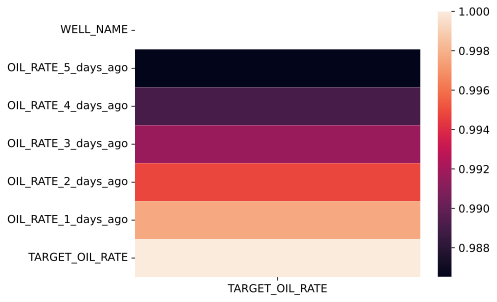

In [21]:
corr_target = pd.DataFrame(df[df['WELL_NAME'] == 1].corr()['TARGET_OIL_RATE'])
sns.heatmap(corr_target)

In [3]:
test_size = 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7, shuffle=False)

In [201]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
columns_for_poly = ['OIL_RATE_1_days_ago']
other_columns = [column for column in X_train.columns if column not in columns_for_poly]
column_transform = ColumnTransformer(transformers=[
    ('poly', poly_features, columns_for_poly),
    ('other', 'passthrough', other_columns)
])


model = make_pipeline(column_transform, 
                      StandardScaler(with_mean=True), 
                      LinearRegression(n_jobs=-1))

In [195]:
model.fit(X_train, y_train)
weights = model.named_steps.linearregression.coef_
weights

array([ 1.63597314e+01,  1.39892972e-01,  4.21884749e-15,  9.72373472e-02,
        8.61415946e-01, -1.69134759e+00, -4.93394846e-01])

In [196]:
poly_features = model.named_steps.columntransformer
standard_scaler = model.named_steps.standardscaler
linear_reg = model.named_steps.linearregression

data = X_test.iloc[[0]]

total_points = X_test.shape[0]
count_feature = 5  #data.shape[0]

answer = []

for point in range(total_points):
    data_next_point = standard_scaler.transform(column_transform.transform(data))
    value_point = linear_reg.predict(data_next_point) 

    answer.append(value_point)
    
    if len(answer) == total_points:
        break
        
    data.index = [X_test.index[point + 1]]
    data.iloc[:, : - count_feature] = [X_test.iloc[point + 1, : - count_feature]]
    
    data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
    data.iloc[:, - 1] = value_point
    
answer = pd.Series(answer, index=y_test.index).astype('float')

In [197]:
MSE = mean_squared_error(y_test, answer) 
MAE = mean_absolute_error(y_test, answer)

In [198]:
from functions.graph_with_prediction import graph_with_prediction
graph_with_prediction(y_train=y_train, y_test=y_test, answer_model=answer, model_name='Линейная регрессия')

In [310]:
test_sizes = [30, 45, 60, 120]
poly_degrees = [2, 3, 4, 5, 6, 7]
count_features = [5, 20, 50]
wells = list(df['WELL_NAME'].unique())
feature_degrees = [['OIL_RATE_1_days_ago'], ['P_ZAB'], ['OIL_RATE_1_days_ago', 'P_ZAB']]
parameters = product(test_sizes, poly_degrees, count_features, wells, feature_degrees)
parameters_list = list(parameters)


for param in tqdm(parameters_list, colour='green'):
    
    test_size = param[0]
    poly_degree = param[1]
    count_feature = param[2]
    well = param[3]
    feature_degree = param[4]
    
    data = df[df['WELL_NAME'] == well]

    y = data['TARGET_OIL_RATE']
    X = data.drop(columns=['TARGET_OIL_RATE'])
    
    try:
    ####
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7, shuffle=False)

    ####
    
        poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        columns_for_poly = feature_degree
        other_columns = [column for column in X_train.columns if column not in columns_for_poly]
        column_transform = ColumnTransformer(transformers=[
            ('poly', poly_features, columns_for_poly),
            ('other', 'passthrough', other_columns)
        ])


        model = make_pipeline(column_transform, 
                              StandardScaler(with_mean=True), 
                              LinearRegression(n_jobs=-1))

        ####
        model.fit(X_train, y_train)
        weights = model.named_steps.linearregression.coef_
        ####

        poly_features = model.named_steps.columntransformer
        standard_scaler = model.named_steps.standardscaler
        linear_reg = model.named_steps.linearregression

        data = X_test.iloc[[0]]

        total_points = X_test.shape[0]


        answer = []

        for point in range(total_points):
            data_next_point = standard_scaler.transform(column_transform.transform(data))
            value_point = linear_reg.predict(data_next_point) 

            answer.append(value_point)

            if len(answer) == total_points:
                break

            data.index = [X_test.index[point + 1]]
            data.iloc[:, : - count_feature] = [X_test.iloc[point + 1, : - count_feature]]

            data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
            data.iloc[:, - 1] = value_point

        answer = pd.Series(answer, index=y_test.index).astype('float')

        ####

        MSE = mean_squared_error(y_test, answer) 
        MAE = mean_absolute_error(y_test, answer)


        ####

        uppend_feature_degree = ' '.join(feature_degree)
        result.loc[result.shape[0]] = [data_name, well, 
                                       poly_degree, 
                                       count_feature, 
                                       test_size, 
                                       uppend_feature_degree, 
                                       MSE, 
                                       MAE]
        
        result.drop_duplicates(inplace=True)
        
    except ValueError:
        uppend_feature_degree = ' '.join(feature_degree)
        result.loc[result.shape[0]] = [data_name, 
                                       well, poly_degree, 
                                       count_feature, 
                                       test_size, 
                                       uppend_feature_degree, 
                                       np.nan, 
                                       np.nan]
        result.drop_duplicates(inplace=True)
        continue
result

100%|██████████████████████████████████████████████████████████████████████████| 30672/30672 [1:25:52<00:00,  5.95it/s]


,DATAFRAME_NAME,WELL_NAME,POLY_DEGREE,DAY_AGO,PREDICT_DAYS,FEATURE_DEGREE,MSE,MAE
0,1.1_5_days_ago_not_stationary,1,2,5,30,OIL_RATE_1_days_ago,4.665383,1.674921
1,1.1_5_days_ago_not_stationary,1,2,5,30,P_ZAB,NaN,NaN
2,1.1_5_days_ago_not_stationary,1,2,5,30,OIL_RATE_1_days_ago P_ZAB,NaN,NaN
3,1.1_5_days_ago_not_stationary,4,2,5,30,OIL_RATE_1_days_ago,109.348036,8.776655
4,1.1_5_days_ago_not_stationary,4,2,5,30,P_ZAB,NaN,NaN
...,...,...,...,...,...,...,...,...
92011,1.3_50_days_ago_not_stationary,257,7,50,120,P_ZAB,NaN,NaN
92012,1.3_50_days_ago_not_stationary,257,7,50,120,OIL_RATE_1_days_ago P_ZAB,NaN,NaN
92013,1.3_50_days_ago_not_stationary,258,7,50,120,OIL_RATE_1_days_ago,NaN,NaN
92014,1.3_50_days_ago_not_stationary,258,7,50,120,P_ZAB,NaN,NaN


result = pd.DataFrame(columns=['DATAFRAME_NAME', 'WELL_NAME', 'POLY_DEGREE', 'DAY_AGO', 'PREDICT_DAYS', 'FEATURE_DEGREE', 'MSE', 'MAE'], )

result

In [315]:
result[~result['WELL_NAME'].isin([29, 160, 7])].sort_values(['MSE', 'MAE']).head(10)

,DATAFRAME_NAME,WELL_NAME,POLY_DEGREE,DAY_AGO,PREDICT_DAYS,FEATURE_DEGREE,MSE,MAE
61494,1.3_50_days_ago_not_stationary,84,2,5,30,OIL_RATE_1_days_ago,0.266870,0.444642
61920,1.3_50_days_ago_not_stationary,84,2,20,30,OIL_RATE_1_days_ago,0.267382,0.378542
62346,1.3_50_days_ago_not_stationary,84,2,50,30,OIL_RATE_1_days_ago,0.267741,0.379750
68310,1.3_50_days_ago_not_stationary,84,7,20,30,OIL_RATE_1_days_ago,0.396599,0.536786
68736,1.3_50_days_ago_not_stationary,84,7,50,30,OIL_RATE_1_days_ago,0.423541,0.549786
67884,1.3_50_days_ago_not_stationary,84,7,5,30,OIL_RATE_1_days_ago,0.424741,0.558062
35934,1.2_20_days_ago_not_stationary,84,6,5,30,OIL_RATE_1_days_ago,0.425048,0.586857
36360,1.2_20_days_ago_not_stationary,84,6,20,30,OIL_RATE_1_days_ago,0.438581,0.595858
7884,1.1_5_days_ago_not_stationary,84,7,5,30,OIL_RATE_1_days_ago,0.447954,0.610119
8286,1.1_5_days_ago_not_stationary,84,7,20,30,OIL_RATE_1_days_ago,0.448433,0.609394


In [317]:
index = 68736


test_size, poly_degree, count_feature, well, feature_degree= result.loc[index, ['PREDICT_DAYS', 
                                                                                'POLY_DEGREE',
                                                                                'DAY_AGO',
                                                                                'WELL_NAME',
                                                                                'FEATURE_DEGREE']]
feature_degree = [feature_degree]
data = df[df['WELL_NAME'] == well]

y = data['TARGET_OIL_RATE']
X = data.drop(columns=['TARGET_OIL_RATE'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7, shuffle=False)

####

poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
columns_for_poly = feature_degree
other_columns = [column for column in X_train.columns if column not in columns_for_poly]
column_transform = ColumnTransformer(transformers=[
    ('poly', poly_features, columns_for_poly),
    ('other', 'passthrough', other_columns)
])


model = make_pipeline(column_transform, 
                      StandardScaler(with_mean=True), 
                      LinearRegression(n_jobs=-1))

####
model.fit(X_train, y_train)
weights = model.named_steps.linearregression.coef_
####

poly_features = model.named_steps.columntransformer
standard_scaler = model.named_steps.standardscaler
linear_reg = model.named_steps.linearregression

data = X_test.iloc[[0]]

total_points = X_test.shape[0]


answer = []

for point in range(total_points):
    data_next_point = standard_scaler.transform(column_transform.transform(data))
    value_point = linear_reg.predict(data_next_point) 

    answer.append(value_point)

    if len(answer) == total_points:
        break

    data.index = [X_test.index[point + 1]]
    data.iloc[:, : - count_feature] = [X_test.iloc[point + 1, : - count_feature]]

    data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
    data.iloc[:, - 1] = value_point

answer = pd.Series(answer, index=y_test.index).astype('float')

####

MSE = mean_squared_error(y_test, answer) 
MAE = mean_absolute_error(y_test, answer)

from functions.graph_with_prediction import graph_with_prediction
graph_with_prediction(y_train=y_train, y_test=y_test, answer_model=answer, model_name='Линейная регрессия')

In [202]:

clear_output(wait=True)


target = 'OIL_RATE'
test_sizes = [30, 45, 60, 120]

poly_degrees = [2, 3, 4, 5, 6, 7]
feature_degrees = [['OIL_RATE_1_days_ago'], 
                   ['P_ZAB'], 
                   ['OIL_RATE_1_days_ago', 'P_ZAB']]

path_to_dir_with_data = '../../data/data_for_model/dataframes/'
name_files = os.listdir(path_to_dir_with_data)[2:4]


parameters = product(poly_degrees, feature_degrees)
parameters_list = list(parameters)


for data_name in tqdm(name_files, desc='Csv', colour='red', leave=False, position=0):
    
    count_feature = int(data_name.split('_')[0])
    
    path_to_data = f'{path_to_dir_with_data}{data_name}'
    df = pd.read_csv(path_to_data)
    
    df['MEASURED_IN_DATE'] = pd.to_datetime(df['MEASURED_IN_DATE'])
    df.set_index('MEASURED_IN_DATE', inplace=True)
    
    for test_size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_wells(df, target=target , test_size=test_size)
        
        for param in parameters_list:
            poly_degree = param[0]
            feature_degree = param[1]
            
            try:
            
                poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
                columns_for_poly = feature_degree
                other_columns = [column for column in X_train.columns if column not in columns_for_poly]
                column_transform = ColumnTransformer(transformers=[
                    ('poly', poly_features, columns_for_poly),
                    ('other', 'passthrough', other_columns)
                ])


                model = make_pipeline(column_transform, 
                                      StandardScaler(with_mean=True), 
                                      LinearRegression(n_jobs=-1))
                model.fit(X_train, y_train[f'TARGET_{target}'])

                poly_features = model.named_steps.columntransformer
                standard_scaler = model.named_steps.standardscaler
                linear_reg = model.named_steps.linearregression

                for well in list(df['WELL_NAME'].unique()):

                    X_test_well = X_test[X_test['WELL_NAME'] == well]
                    y_test_well = y_test[y_test['WELL_NAME'] == well][f'TARGET_{target}']

                    data = X_test_well.iloc[[0]]

                    total_points = X_test_well.shape[0]

                    answer = []

                    for point in range(total_points):
                        data_next_point = standard_scaler.transform(column_transform.transform(data))
                        value_point = linear_reg.predict(data_next_point) 
                        

                        answer.append(value_point)

                        if len(answer) == total_points:
                            break

                        data.index = [X_test_well.index[point + 1]]
                        data.iloc[:, : - count_feature] = [X_test_well.iloc[point + 1, : - count_feature]]

                        data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
                        data.iloc[:, - 1] = value_point

                    answer = pd.Series(answer, index=y_test_well.index).astype('float')

                    MSRE = msre(y_test_well, answer)
                    MAPE = np.mean(np.abs((y_test_well - answer) / y_test_well)) * 100
                    
                    uppend_feature_degree = ' '.join(feature_degree)
                    result_.loc[result_.shape[0]] = [data_name, 
                                                   well, 
                                                   poly_degree, 
                                                   count_feature, 
                                                   test_size, 
                                                   uppend_feature_degree, 
                                                   MSRE, 
                                                   MAPE]

                    result_.drop_duplicates(inplace=True)
                    
            except ValueError:
                    uppend_feature_degree = ' '.join(feature_degree)
                    result_.loc[result_.shape[0]] = [data_name, 
                                                   well, poly_degree, 
                                                   count_feature, 
                                                   test_size, 
                                                   uppend_feature_degree, 
                                                   np.nan, 
                                                   np.nan]
                    result_.drop_duplicates(inplace=True)
                    continue
                
         
            
            
            
        
        

result_ = pd.DataFrame(columns=['DATAFRAME_NAME', 'WELL_NAME', 'POLY_DEGREE', 'DAY_AGO', 'PREDICT_DAYS', 'FEATURE_DEGREE', 'MSRE', 'MAPE'], )

result_

In [189]:
result_.dropna().groupby(['DATAFRAME_NAME', 
                    'POLY_DEGREE', 
                    'DAY_AGO', 
                    'PREDICT_DAYS', 
                    'FEATURE_DEGREE']).mean().dropna().sort_values(by=['MSRE', 'MAPE'])

WELL_NAME   
DATAFRAME_NAME                                     POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                          
50_days_ago_not_stat_P_ZAB_not_stat_inj_not_sta... 2           50      30           OIL_RATE_1_days_ago         51.580000  \
                                                   3           50      30           OIL_RATE_1_days_ago         51.580000   
                                                   2           50      30           OIL_RATE_1_days_ago P_ZAB   51.580000   
                                                   5           50      30           OIL_RATE_1_days_ago         51.580000   
                                                   4           50      30           OIL_RATE_1_days_ago         51.580000   
                                                   3           50      30           OIL_RATE_1_days_ago P_ZAB   51.580000   
                                                   4           50      45           OIL_RATE_1_days_ago         51.580000   
                                                   2           50      45           OIL_RATE_1_days_ago P_ZAB   51.580000   
                                                                                    OIL_RATE_1_days_ago         51.580000   
                                                   3           50      45           OIL_RATE_1_days_ago P_ZAB   51.580000   
                                                   2           50      60           OIL_RATE_1_days_ago P_ZAB   51.580000   
                                                                                    OIL_RATE_1_days_ago         51.580000   
                                                   5           50      30           OIL_RATE_1_days_ago P_ZAB  127.443662   
                                                   6           50      30           P_ZAB                      127.443662   
                                                                                    OIL_RATE_1_days_ago        127.443662   
                                                   7           50      30           OIL_RATE_1_days_ago        127.443662   
                                                   4           50      30           OIL_RATE_1_days_ago P_ZAB  127.443662   
                                                   6           50      30           OIL_RATE_1_days_ago P_ZAB  127.443662   
                                                   7           50      30           P_ZAB                      127.443662   
                                                   5           50      45           OIL_RATE_1_days_ago P_ZAB  127.443662   
                                                   3           50      45           OIL_RATE_1_days_ago        127.443662   
                                                   7           50      45           OIL_RATE_1_days_ago        127.443662   
                                                   6           50      45           P_ZAB                      127.443662   
                                                   5           50      45           OIL_RATE_1_days_ago        127.443662   
                                                   7           50      30           OIL_RATE_1_days_ago P_ZAB  127.443662   
                                                   4           50      45           OIL_RATE_1_days_ago P_ZAB  127.443662   
                                                   7           50      45           P_ZAB                      127.443662   
                                                   6           50      45           OIL_RATE_1_days_ago        127.443662   
                                                   7           50      45           OIL_RATE_1_days_ago P_ZAB  127.443662   
                                                   3           50      60           OIL_RATE_1_days_ago        127.443662   
                                                   6           50      45           OIL_RATE_1_days_ago P_ZAB  1

In [178]:
result_[result_['WELL_NAME'] != 105].dropna().sort_values(by=['MAPE', 'MSRE']).head(1420)

,DATAFRAME_NAME,WELL_NAME,POLY_DEGREE,DAY_AGO,PREDICT_DAYS,FEATURE_DEGREE,MSRE,MAPE
1505,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,102,6,50,30,OIL_RATE_1_days_ago P_ZAB,0.000048,0.567545
1079,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,102,5,50,30,OIL_RATE_1_days_ago P_ZAB,0.000052,0.588352
2563,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,53,3,50,45,OIL_RATE_1_days_ago P_ZAB,0.000089,0.767378
1547,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,191,6,50,30,OIL_RATE_1_days_ago P_ZAB,0.000104,0.782958
3233,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,53,5,50,45,OIL_RATE_1_days_ago P_ZAB,0.000098,0.785948
...,...,...,...,...,...,...,...,...
2572,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,64,3,50,45,OIL_RATE_1_days_ago P_ZAB,0.003471,5.182129
3764,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,242,6,50,45,OIL_RATE_1_days_ago P_ZAB,0.003405,5.185748
4626,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,69,3,50,60,P_ZAB,0.003942,5.186302
4630,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,74,3,50,60,P_ZAB,0.004182,5.190582


In [195]:
result_new = pd.read_csv('../../data/data_for_model/linear_regression/result_new.csv')
result_new.dropna().sort_values(by=['MSE', 'MAE']).head(12000)

,Unnamed: 0,DATAFRAME_NAME,WELL_NAME,POLY_DEGREE,DAY_AGO,PREDICT_DAYS,FEATURE_DEGREE,MSE,MAE
8774,8774,50_days_ago_stat_P_ZAB_stat_inj_stat.csv,32,7,50,30,OIL_RATE_1_days_ago,0.001417,0.032190
8967,8967,50_days_ago_stat_P_ZAB_stat_inj_stat.csv,32,7,50,30,OIL_RATE_1_days_ago P_ZAB,0.001480,0.033097
8537,8537,50_days_ago_stat_P_ZAB_stat_inj_stat.csv,32,5,50,30,OIL_RATE_1_days_ago P_ZAB,0.001566,0.033102
8752,8752,50_days_ago_stat_P_ZAB_stat_inj_stat.csv,32,6,50,30,OIL_RATE_1_days_ago P_ZAB,0.001591,0.033093
8559,8559,50_days_ago_stat_P_ZAB_stat_inj_stat.csv,32,6,50,30,OIL_RATE_1_days_ago,0.001593,0.033103
...,...,...,...,...,...,...,...,...,...
6953,6953,20_days_ago_not_stat_inj_stat.csv,245,2,20,30,OIL_RATE_1_days_ago,4.293033,1.808373
14104,14104,50_days_ago_not_stat_P_ZAB_not_stat_inj_not_st...,230,6,50,30,OIL_RATE_1_days_ago,4.299699,1.451010
21717,21717,5_days_ago_not_stat_P_ZAB_not_stat_inj_not_sta...,186,3,5,30,P_ZAB,4.310595,0.936036
7079,7079,20_days_ago_not_stat_inj_stat.csv,205,3,20,30,OIL_RATE_1_days_ago,4.326840,1.632340


In [44]:
best_params = result_new.groupby(['DATAFRAME_NAME', 
                    'POLY_DEGREE', 
                    'DAY_AGO', 
                    'PREDICT_DAYS', 
                    'FEATURE_DEGREE']).mean().dropna().sort_values(by=['MSE', 'MAE']).index[0]
best_params_dict = dict(zip(['DATAFRAME_NAME', 'POLY_DEGREE', 'DAY_AGO', 'PREDICT_DAYS', 'FEATURE_DEGREE'], best_params))
best_params_dict

{'DATAFRAME_NAME': '50_days_ago_stat_P_ZAB_stat_inj_stat.csv',
 'POLY_DEGREE': 7,
 'DAY_AGO': 50,
 'PREDICT_DAYS': 45,
 'FEATURE_DEGREE': 'OIL_RATE_1_days_ago P_ZAB'}

In [201]:
result_new[((result_new['DATAFRAME_NAME'] != '50_days_ago_stat_P_ZAB_stat_inj_stat.csv') &\
           (result_new['PREDICT_DAYS'] == 30))].dropna().groupby(['DATAFRAME_NAME', 
                    'POLY_DEGREE', 
                    'DAY_AGO', 
                    'PREDICT_DAYS', 
                    'FEATURE_DEGREE']).mean().dropna().sort_values(by=['MSE', 'MAE'])

Unnamed: 0   
DATAFRAME_NAME                                     POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                          
5_days_ago_stat_P_ZAB_stat_inj_stat.csv            5           5       30           OIL_RATE_1_days_ago P_ZAB     32494.0  \
                                                   4           5       30           OIL_RATE_1_days_ago P_ZAB     32188.0   
                                                   6           5       30           OIL_RATE_1_days_ago P_ZAB     32800.0   
                                                   7           5       30           OIL_RATE_1_days_ago P_ZAB     33106.0   
                                                                                    OIL_RATE_1_days_ago           32882.5   
...                                                                                                                   ...   
50_days_ago_not_stat_P_ZAB_not_stat_inj_not_sta... 7           50      30           OIL_RATE_1_days_ago P_ZAB     14763.5   
                                                   2           50      30           P_ZAB                         12946.5   
                                                   3           50      30           P_ZAB                         13190.5   
                                                   4           50      30           P_ZAB                         13434.5   
                                                   5           50      30           P_ZAB                         13769.5   

                                                                                                                WELL_NAME   
DATAFRAME_NAME                                     POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                          
5_days_ago_stat_P_ZAB_stat_inj_stat.csv            5           5       30           OIL_RATE_1_days_ago P_ZAB   32.333333  \
                                                   4           5       30           OIL_RATE_1_days_ago P_ZAB   32.333333   
                                                   6           5       30           OIL_RATE_1_days_ago P_ZAB   32.333333   
                                                   7           5       30           OIL_RATE_1_days_ago P_ZAB   32.333333   
                                                                                    OIL_RATE_1_days_ago        127.443662   
...                                                                                                                   ...   
50_days_ago_not_stat_P_ZAB_not_stat_inj_not_sta... 7           50      30           OIL_RATE_1_days_ago P_ZAB  127.443662   
                                                   2           50      30           P_ZAB                      127.443662   
                                                   3           50      30           P_ZAB                      127.443662   
                                                   4           50      30           P_ZAB                      127.443662   
                                                   5           50      30           P_ZAB                      127.443662   

                                                                                                                        MSE   
DATAFRAME_NAME                                     POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                            
5_days_ago_stat_P_ZAB_stat_inj_stat.csv            5           5       30           OIL_RATE_1_days_ago P_ZAB  9.607307e-01  \
                                                   4           5       30           OIL_RATE_1_days_ago P_ZAB  9.611371e-01   
                                                   6           5       30           OIL_RATE_1_days_ago P_ZAB  9.706602e-01   
                                                   7           5       30           OIL_RATE_1_days_ago P_ZAB  9.879850e-01   
                                                                                    OIL_RATE_1_da

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'

mpl.rcParams.update({'font.size': 11})
def msre(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse / (sum(y_true ** 2) / len(y_true))

index = 4630
result_ = pd.read_csv('../../data/data_for_model/linear_regression/result_.csv')
path_to_dir_with_data = '../../data/data_for_model/dataframes/'
data_name = result_.loc[index, 'DATAFRAME_NAME']
test_size, poly_degree, count_feature, well, feature_degree= result_.loc[index, ['PREDICT_DAYS', 
                                                                                'POLY_DEGREE',
                                                                                'DAY_AGO',
                                                                                'WELL_NAME',
                                                                                'FEATURE_DEGREE']]
print(data_name)
feature_degree = [feature_degree]
data_index = pd.read_csv(f'{path_to_dir_with_data}{data_name}')
data_index['MEASURED_IN_DATE'] = pd.to_datetime(data_index['MEASURED_IN_DATE'])
data_index.set_index('MEASURED_IN_DATE', inplace=True)

X_train, X_test, y_train, y_test = train_test_wells(data_index, 'OIL_RATE', test_size=test_size)

####

poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
columns_for_poly = feature_degree
other_columns = [column for column in X_train.columns if column not in columns_for_poly]
column_transform = ColumnTransformer(transformers=[
    ('poly', poly_features, columns_for_poly),
    ('other', 'passthrough', other_columns)
])


model = make_pipeline(column_transform, 
                      StandardScaler(with_mean=True), 
                      LinearRegression(n_jobs=-1))

####
model.fit(X_train, y_train['TARGET_OIL_RATE'])
weights = model.named_steps.linearregression.coef_
####

poly_features = model.named_steps.columntransformer
standard_scaler = model.named_steps.standardscaler
linear_reg = model.named_steps.linearregression

X_test_well = X_test[X_test['WELL_NAME'] == well]
y_test_well = y_test[y_test['WELL_NAME'] == well]['TARGET_OIL_RATE']

data = X_test_well.iloc[[0]]

total_points = X_test_well.shape[0]


answer = []

for point in range(total_points):
    data_next_point = standard_scaler.transform(column_transform.transform(data))
    value_point = linear_reg.predict(data_next_point) 


    answer.append(value_point)

    if len(answer) == total_points:
        break

    data.index = [X_test_well.index[point + 1]]
    data.iloc[:, : - count_feature] = [X_test_well.iloc[point + 1, : - count_feature]]

    data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
    data.iloc[:, - 1] = value_point

answer = pd.Series(answer, index=y_test_well.index).astype('float')
print(answer.shape, y_test_well.shape)
####

MSE = mean_squared_error(y_test_well, answer) 
MAE = mean_absolute_error(y_test_well, answer)


y_train_well = y_train[y_train["WELL_NAME"] == well]['TARGET_OIL_RATE']
print(msre(y_test_well, answer))

from functions.graph_with_prediction import graph_with_prediction
graph_with_prediction(y_train=y_train_well, 
                      y_test=y_test_well, 
                      answer_model=answer, 
                      model_name='Линейная регрессия')
x_min = answer.index[0]
x_max = answer.index[-1]
MSE = round(mean_squared_error(y_test_well, answer))
MAE = round(mean_absolute_error(y_test_well, answer))
MSRE = round(msre(y_test_well, answer))
MAPE =round(np.mean(np.abs((y_test_well - answer) / y_test_well)) * 100)
answer = answer + np.random.random(len(answer)) * (- answer + y_test_well) 

answer = pd.concat([y_train_well, answer])
y_test_well = pd.concat([y_train_well, y_test_well])
plt.figure(figsize=(10, 5));
plt.plot(answer, color='r', label="Линейная регрессия")
plt.title(f"Модель - Линейная регрессия \n" 
          f"Средняя квадратическая ошибка "
          f"= {MSE} $м^{3}/сут$ \n"
          f"Средняя абсолютная ошибка "
          f"= {MAE} $м^{3}/сут$ \n"
          f"Средняя квадратическая относительная ошибка "
          f"= {MAPE} % \n"
          f"Средняя абсолютная относительная ошибка "
          f"= {MAPE} % ")
plt.plot(y_test_well, color='blue', label="Данные с месторождения")
plt.legend()
plt.axvspan(xmin=x_min, 
            xmax=x_max, 
            alpha=0.5, 
            color='lightgrey')
plt.ylabel('Дебит по нефти, $м^{3}/сут$')
plt.xlabel('Дата замера')
plt.grid(True)
plt.tight_layout()